*Теоретический материал:* https://youtu.be/shzJQxepN-s?t=868

**Распознавание изображений из набора данных MNIST, CIFAR-10 и базы автомобилей с помощью свёрточных нейронных сетей**
---

*Разбор данного раздела:* https://youtu.be/shzJQxepN-s?t=3486

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (File->Save a copy in Drive...). Свою копию вы сможете изменять и запускать.



**Иморт библиотек для работы всего ноутбука**

In [0]:
from tensorflow.keras.datasets import mnist #Загружаем базу mnist
from tensorflow.keras.datasets import cifar10 #Загружаем базу cifar10
from tensorflow.keras.datasets import cifar100 #Загружаем базу cifar100

from tensorflow.keras.models import Sequential #Сеть прямого распространения
#Базовые слои для счёрточных сетей
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator # работа с изображениями
from tensorflow.keras.optimizers import Adam, Adadelta # оптимизаторы
from tensorflow.keras import utils #Используем дял to_categoricall
from tensorflow.keras.preprocessing import image #Для отрисовки изображений
from google.colab import files #Для загрузки своей картинки
import numpy as np #Библиотека работы с массивами
import matplotlib.pyplot as plt #Для отрисовки графиков
from PIL import Image #Для отрисовки изображений
import random #Для генерации случайных чисел 
import math # Для округления
import os #Для работы с файлами 
# подключем диск
from google.colab import drive

%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Распознавание изображений из набора данных MNIST 


**Подготовка данных**

*Разбор данного раздела:* https://youtu.be/shzJQxepN-s?t=3575

In [0]:
#Загружаем MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

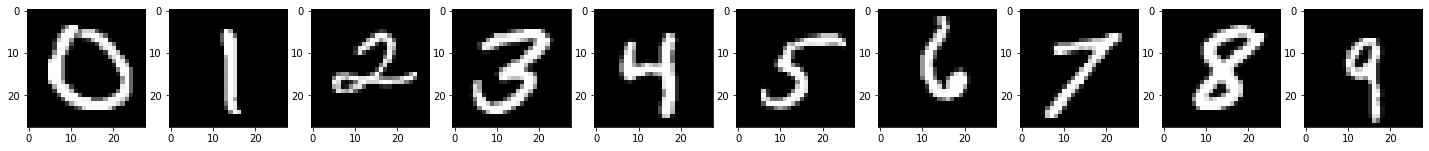

In [0]:
#Выводим для примера картинки по каждому классу

fig, axs = plt.subplots(1, 10, figsize=(25, 3)) #Создаем полотно из 10 графиков
for i in range(10): #Проходим по классам от 0 до 9
  label_indexes = np.where(y_train==i)[0] #Получаем список из индексов положений класса i в y_train
  index = random.choice(label_indexes) #Случайным образом выбираем из списка индекс
  img = x_train[index] #Выбираем из x_train нужное изображение
  axs[i].imshow(Image.fromarray(img), cmap='gray') #Отображаем изображение i-ым графиков

plt.show() #Показываем изображения

In [0]:
#Превращаем y_train и y_test сетей в формат one hot encoding
y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)

#Меняем формат данных MNIST
#Надо добавить в конце размерность 1
#Чтобы свёрточная сеть понимала, что это чёрно-белые данные
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [0]:
# Посмотрим форматы выборок перед обучением
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

**Нейронная сеть**

*Разбор данного раздела:* https://youtu.be/shzJQxepN-s?t=3677

In [0]:
#задаём batch_size
batch_size = 128 

#Создаем последовательную модель
model = Sequential()
#Слой пакетной нормализации
model.add(BatchNormalization(input_shape=(28, 28, 1)))
#Первый сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
#Второй сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
#Первый слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
#Слой регуляризации Dropout
model.add(Dropout(0.25))

model.add(Flatten())
#Полносвязный слой для классификации
model.add(Dense(256, activation='relu'))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Выходной полносвязный слой
model.add(Dense(10, activation='softmax'))

#Компилируем сеть
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#Обучаем сеть на данных mnist
history = model.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=15,
                    validation_data=(x_test, y_test),
                    verbose=1)

#Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [0]:
model.summary()

**Определение цифр из тестовой выборки**

*Разбор данного раздела:* https://youtu.be/shzJQxepN-s?t=5746

In [0]:
#Выбираем номер пример
n = 2020
#Получаем выход сети на этом примере
prediction = model.predict(x_test)

#Выводим на экран результаты
print("Выход сети: ", prediction[n])
print("Распознанная цифра: ", np.argmax(prediction[n]))
print("Верный ответ: ", np.argmax(y_test[n]))

**Определение цифр на реальных фотографиях**

In [0]:
!unzip '/content/drive/My Drive/Занятия/Апрельский курс 2020/Занятие №3/digits.zip' #Извлечем файлы из архива

In [0]:
#Выводим для примера картинки по каждому классу

def change_contrast(img, factor): #Функция для увеличения контрастности 
    def contrast(pixel): #Функция для изменения цвета пикселя
    #Изменяем цвет каждого пикселя следующим образом. 
    #Если цвет пикслея в численной мере меньше 128, то значение будет уменьшаться 
    #на меру factor * (pixel - 128). Иначе - увеличиваться на эту меру
    #Очевидно, что чем сильнее цвет отличен от 128, тем сильнее он изменится
        return 128 + factor * (pixel - 128) 
    return img.point(contrast)

xTestReal = [] #Создаем x_test для загруженных картинок
yTestReal = [] #Создаем y_test для классов изображений

for i in range(10): #Проходим по классам от 0 до 9
  img_path = 'digits/' + str(i) + '.png' #Определяем имя изображения
  #Загружаем изображение, изменяя его размер на размер входного массива нейросети
  #Другими словами, подгоняем изображение к размеру картинок, на которых обучалась сеть
  #Указываем grayscale=True для того, чтобы цвет пиксяля задавался одним числом
  img = image.load_img(img_path, grayscale=True, target_size=(28, 28))
  img1 = change_contrast(img, factor=5.0) #Увеличиваем контрастность изображения
  xTestReal.append(255 - np.asarray(img1)) #Инвертируем изображение и добавляем в выборку
  yTestReal.append(i) #Добавляем в y_train номера классов

xTestReal = np.array(xTestReal) #Преобразуем в Numpy array
yTestReal = np.array(yTestReal) #Преобразуем в Numpy array

In [0]:
#Выводим для примера картинки по каждому классу

fig, axs = plt.subplots(1, 10, figsize=(25, 3)) #Создаем полотно из 10 графиков
for i in range(10): #Проходим по классам от 0 до 9
  axs[i].imshow(Image.fromarray(xTestReal[i]), cmap='gray') #Конвертируем изображение в черно-белый формат и отображаем i-ым графиков

plt.show() #Показываем изображения

In [0]:
#Меняем формат данных, как делали это с выборкой MNIST
xTestReal = xTestReal.reshape(xTestReal.shape[0], 28, 28, 1)

In [0]:
xTestReal.shape #Посмотрим на размер массива, чтобы убедиться, что все сделали правильно

In [0]:
prediction = model.predict(xTestReal) #Классифицируем каждое изображение
for i in range(10): #Проходим по картинкам
  #Вводим результаты на экран
  print("Распознанный образ:", np.argmax(prediction[i]), '. Верный ответ', yTestReal[i])

# Распознавание изображений из набора данных Cifar10

*Разбор данного раздела:* https://youtu.be/shzJQxepN-s?t=5890

In [0]:
#Загружаем cifar10
(x_train10, y_train10), (x_test10, y_test10) = cifar10.load_data()

In [0]:
#Определяем названия классов по порядку
classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [0]:
#Выводим для примера картинки по каждому классу

fig, axs = plt.subplots(1, 10, figsize=(25, 3)) #Создаем полотно из 10 графиков
for i in range(10): #Проходим по классам от 0 до 9
  label_indexes = np.where(y_train10==i)[0] #Получаем список из индексов положений класса i в y_train
  index = random.choice(label_indexes) #Случайным образом выбираем из списка индекс
  img = x_train10[index] #Выбираем из x_train нужное изображение
  axs[i].imshow(Image.fromarray(img)) #Отображаем изображение i-ым графиков

plt.show() #Показываем изображения

In [0]:
#Превращаем y_train и y_test сетей в формат one hot encoding
y_train10 = utils.to_categorical(y_train10, 10)
y_test10 = utils.to_categorical(y_test10, 10)

In [0]:
# Посмотрим размеры выборок перед обучением
print(x_train10.shape)
print(x_test10.shape)
print(y_train10.shape)
print(y_test10.shape)

**Нейронная сеть**

*Разбор данного раздела:* https://youtu.be/shzJQxepN-s?t=5991

In [0]:
#задаём batch_size
batch_size = 128 

#Создаем последовательную модель
model = Sequential()
#Слой пакетной нормализации
model.add(BatchNormalization(input_shape=(32, 32, 3)))
#Первый сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
#Второй сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
#Первый слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
#Слой регуляризации Dropout
model.add(Dropout(0.25))

#Слой пакетной нормализации
model.add(BatchNormalization())
#Третий сверточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#Четвертый сверточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#Второй слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
#Слой регуляризации Dropout
model.add(Dropout(0.25))

#Слой пакетной нормализации
model.add(BatchNormalization())
#Пятый сверточный слой
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
#Шестой сверточный слой
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
#Третий слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
#Слой регуляризации Dropout
model.add(Dropout(0.25))

#Слой преобразования данных из 2D представления в плоское
model.add(Flatten())
#Полносвязный слой для классификации
model.add(Dense(512, activation='relu'))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Выходной полносвязный слой
model.add(Dense(10, activation='softmax'))

#Компилируем сеть
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#Обучаем сеть на данных cifar10
history = model.fit(x_train10, 
                    y_train10, 
                    batch_size=batch_size, 
                    epochs=20,
                    validation_data=(x_test10, y_test10),
                    verbose=1)

#Оображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

**Определение изображений из тестовой выборки**

*Разбор данного раздела:* https://youtu.be/shzJQxepN-s?t=6616

In [0]:
#Распознаём все тестовые картинки
prediction = model.predict(x_test10)

In [0]:
#Выбираем номер пример
n = 2027

#Выводим на экран картинку
plt.imshow(Image.fromarray(x_test10[n]).convert('RGBA'))
plt.show()

#Выводим на экран результаты
print("Выход сети: ", prediction[n])
print("Распознанный образ: ", np.argmax(prediction[n]))
print("Верный ответ: ", y_test10[n])
print("Распознанный браз на картинке: ", classes[np.argmax(prediction[n])])

**Определение фотографий из интернета**

*Разбор данного раздела:* https://youtu.be/shzJQxepN-s?t=6679

In [0]:
!unzip '/content/drive/My Drive/Занятия/Апрельский курс 2020/Занятие №3/Images.zip' #Извлечем файлы из архива

In [0]:
#Выводим для примера картинки по каждому классу

xTestReal10 = [] #Создаем x_test для загруженных картинок
yTestReal10 = [] #Создаем y_test для классов изображений

for i in range(10): #Проходим по классам от 0 до 9
  img_path = 'Images/' + str(i) + '.jpg' #Определяем имя изображения
  #Загружаем изображение, изменяя его размер на размер входного массива нейросети
  #Другими словами, подгоняем изображение к размеру картинок, на которых обучалась сеть

  xTestReal10.append(np.asarray(image.load_img(img_path, grayscale=False, target_size=(32, 32)))) #Добавляем изображение в выборку
  yTestReal10.append(i) #Добавляем в y номера классов

xTestReal10 = np.array(xTestReal10) #Преобразуем в Numpy array
yTestReal10 = np.array(yTestReal10) #Преобразуем в Numpy array

In [0]:
#Выводим для примера картинки по каждому классу

fig, axs = plt.subplots(1, 10, figsize=(25, 3)) #Создаем полотно из 10 графиков
for i in range(10): #Проходим по классам от 0 до 9
  axs[i].imshow(Image.fromarray(xTestReal10[i]).convert('RGB')) #Конвертируем изображение в черно-белый формат и отображаем i-ым графиков

plt.show() #Показываем изображения

In [0]:
xTestReal10.shape #Посмотрим на размер массива, чтобы убедиться, что все сделали правильно

In [0]:
prediction = model.predict(xTestReal10) #Классифицируем каждое изображение
for i in range(10): #Проходим по картинкам
  #Вводим результаты на экран
  print("Распознанный образ:", classes[np.argmax(prediction[i])])
  print('Верный ответ:', classes[yTestReal10[i]])
  print()

#Распознавание изображений из набора данных Cifar100

*Разбор данного раздела:* https://youtu.be/shzJQxepN-s?t=6753

In [0]:
#Загружаем cifar100
(x_train100, y_train100), (x_test100, y_test100) = cifar100.load_data()

In [0]:
#Выводим для примера картинки по первым 10 классам

fig, axs = plt.subplots(1, 10, figsize=(25, 3)) #Создаем полотно из 10 графиков
for i in range(10): #Проходим по классам от 0 до 9
  label_indexes = np.where(y_train100==i)[0] #Получаем список из индексов положений класса i в y_train
  index = random.choice(label_indexes) #Случайным образом выбираем из списка индекс
  img = x_train100[index] #Выбираем из x_train нужное изображение
  axs[i].imshow(Image.fromarray(img)) #Отображаем изображение i-ым графиков

plt.show() #Показываем изображения

In [0]:
#Превращаем y_train и y_test сетей в формат one hot encoding
y_train100 = utils.to_categorical(y_train100, 100)
y_test100 = utils.to_categorical(y_test100, 100)

In [0]:
# Посмотрим размеры выборок перед обучением
print(x_train100.shape)
print(x_test100.shape)
print(y_train100.shape)
print(y_test100.shape)

**Нейронная сеть**

In [0]:
#задаём batch_size
batch_size = 128 

#Создаем последовательную модель
model = Sequential()
#Слой пакетной нормализации
model.add(BatchNormalization(input_shape=(32, 32, 3)))
#Первый сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
#Второй сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
#Первый слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
#Слой регуляризации Dropout
model.add(Dropout(0.25))

#Слой пакетной нормализации
model.add(BatchNormalization())
#Третий сверточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#Четвертый сверточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#Второй слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
#Слой регуляризации Dropout
model.add(Dropout(0.25))

#Слой пакетной нормализации
model.add(BatchNormalization())
#Пятый сверточный слой
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
#Шестой сверточный слой
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
#Третий слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
#Слой регуляризации Dropout
model.add(Dropout(0.25))

#Слой преобразования данных из 2D представления в плоское
model.add(Flatten())
#Полносвязный слой для классификации
model.add(Dense(512, activation='relu'))
#Слой регуляризации Dropout
model.add(Dropout(0.25))
#Выходной полносвязный слой
model.add(Dense(100, activation='softmax'))

#Компилируем сеть
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#Обучаем сеть на данных cifar100
history = model.fit(x_train100, 
                    y_train100, 
                    batch_size=batch_size, 
                    epochs=40,
                    validation_data=(x_train100, y_train100),
                    verbose=1)

#Оображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [0]:
model.summary()

#Распознавание марок машин (маленькая база)

*Разбор данного раздела:* https://youtu.be/shzJQxepN-s?t=6802

In [0]:
!unzip -q "/content/drive/My Drive/Занятия/Апрельский курс 2020/Занятие №3/middle_fmr.zip" -d /content/cars #Указываем путь к базе в Google Drive

In [0]:
train_path = '/content/cars' #Папка с папками картинок, рассортированных по категориям
batch_size = 25 #Размер выборки
img_width = 96 #Ширина изображения
img_height = 54 #Высота изображения

In [0]:
#Генератор изображений
datagen = ImageDataGenerator(
    rescale=1. / 255, #Значения цвета меняем на дробные показания
    rotation_range=10, #Поворачиваем изображения при генерации выборки
    width_shift_range=0.1, #Двигаем изображения по ширине при генерации выборки
    height_shift_range=0.1, #Двигаем изображения по высоте при генерации выборки
    zoom_range=0.1, #Зумируем изображения при генерации выборки
    horizontal_flip=True, #Отключаем отзеркаливание изображений
    fill_mode='nearest', #Заполнение пикселей вне границ ввода
    validation_split=0.1 #Указываем разделение изображений на обучающую и тестовую выборку
)

In [0]:
# обучающая выборка
train_generator = datagen.flow_from_directory(
    train_path, #Путь ко всей выборке выборке
    target_size=(img_width, img_height), #Размер изображений
    batch_size=batch_size, #Размер batch_size
    class_mode='categorical', #Категориальный тип выборки. Разбиение выборки по маркам авто 
    shuffle=True, #Перемешивание выборки
    subset='training' # устанавливаем как набор для обучения
)

# проверочная выборка
validation_generator = datagen.flow_from_directory(
    train_path, #Путь ко всей выборке выборке
    target_size=(img_width, img_height), #Размер изображений
    batch_size=batch_size, #Размер batch_size
    class_mode='categorical', #Категориальный тип выборки. Разбиение выборки по маркам авто 
    shuffle=True, #Перемешивание выборки
    subset='validation' # устанавливаем как валидационный набор
)

Found 3086 images belonging to 3 classes.
Found 341 images belonging to 3 classes.


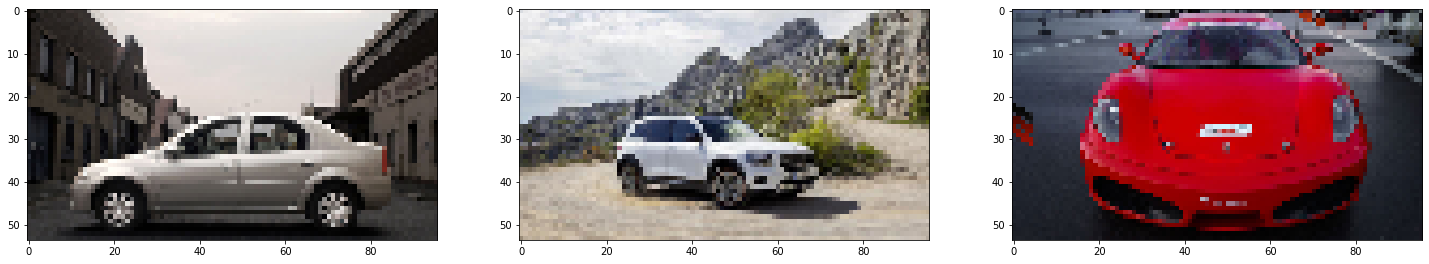

In [0]:
#Выводим для примера картинки по каждому классу

fig, axs = plt.subplots(1, 3, figsize=(25, 5)) #Создаем полотно из 3 графиков
for i in range(3): #Проходим по всем классам
  car_path = train_path + '/' + os.listdir(train_path)[i] + '/'#Формируем путь к выборке
  img_path = car_path + random.choice(os.listdir(car_path)) #Выбираем случайное фото для отображения
  axs[i].imshow(image.load_img(img_path, target_size=(img_height, img_width))) #Отображение фотографии

plt.show() #Показываем изображения

In [0]:
#Создаем последовательную модель
model = Sequential()
#Первый сверточный слой
model.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(img_width, img_height, 3)))
#Второй сверточный слой
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
#Третий сверточный слой
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
#Слой регуляризации Dropout
model.add(Dropout(0.2))
#Четвертый сверточный слой
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
#Слой регуляризации Dropout
model.add(Dropout(0.2))
#Пятый сверточный слой
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
#Шестой сверточный слой
model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
#Слой регуляризации Dropout
model.add(Dropout(0.2))
#Слой преобразования двумерных данных в одномерные 
model.add(Flatten())
#Полносвязный слой
model.add(Dense(2048, activation='relu'))
#Полносвязный слой
model.add(Dense(4096, activation='relu'))
#Вызодной полносвязный слой
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

In [0]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=45,
    verbose=1
)

In [0]:
model.summary()

In [0]:
#Оображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#Глоссарий

**Сверточная нейронная сеть** - архитектура нейронных сетей, направленная на решение задачи распознавания образов 

---

**Dense** - полносвязный слой 

**conv2D** - сверточный слой 

**MaxPooling2D** - слой объединения для пространственных данных 

**Dropout** - случайная блокировка нейронов для предотвращения переобучения

**BatchNormalization** - слой пакетной нормализации

**categorical_crossentropy** - метод определения ошибки нейронной сети для категориальных данных (классов). Категориальная кроссцентропия между выходным результатом и y_train.

**Flatten** - слой преобразования двумерных данных в одномерные

#Литература

Для более глубокого понимания использования библиотеки хорошо уметь искать информацию в документациях от разработчика. Официальная документация доступна на английском языке.

**Документация Keras** - https://keras.io/ 

**Русскоязычная документация Keras** - https://ru-keras.com/ 

Помимо официальной документации можно найти огромное количество полезной информации и в других источниках.

**Полезные статьи habr:**

https://habr.com/ru/post/348000/

https://habr.com/ru/post/309508/